# Get constant offset model posterior

Getting posterior from offset model is not trivial and the following code shows how to do it.

The offset we print follow the following equation
> Gaia parallax = True parallax + offset

**restart your ipython kernel everytime you run it**

In [1]:
import numpy as np

from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

cpu_gpu_check()  # manage GPU memory with astroNN if neccessary, otherwise use CPU
keras = keras_import_manager()  # manage Keras import with astroNN according to astroNN's config.ini
Model = keras.models.Model

net = load_folder("astroNN_constant_model")
# create new model to get offset posterior
model = Model(inputs=net.keras_model.input, outputs=net.get_layer("offset_output").output)

# To get offset posterior
# 1.412.... is a normalization factor used during training, so here we denormalize it and convert it to uas by *1000
offset = model.predict({'input': np.ones((1000, 7518, 1)), 'labels_err': np.ones((1000, 1)), 
                        'input_err': np.ones((1000, 7518, 1))}) * 1.4124689064768827 * 1000
mean, std = np.mean(offset), np.std(offset)
print(f"Offset: {mean:.1f}+/-{std:.1f}")

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN
Offset: -52.3+/-2.0


# Get multivariate offset model posterior

Getting posterior from offset model is not trivial just by using ``astroNN`` and the following code shows how to do it, sampling 10 times

The offset we print follow the following equation
> Gaia parallax = True parallax + offset

**restart your ipython kernel everytime you run it**

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN
G mag:  [  1.17917354 -38.65546753 261.1271158 ] [1.66040745e-04 1.29364550e-01 6.22394155e+00]
DP_RP:  [  6.90437316 -34.63538057 -11.6736862 ] [0.00398715 0.05321488 0.03645931]
T_eff:  [ 6.55151726e-06 -4.51013697e-02  1.71183322e+01] [1.70191318e-14 1.64637768e-06 9.88731042e+00]

Plane fit parameter:  [ -0.50085648  -0.76178235   4.70799757   1.56812836 -66.01738305
  29.3169455 ]
Parameter uncertainty:  [8.46066515e-04 1.19877415e-02 1.00894717e-02 4.68284890e-01
 1.29780933e+00 1.64110147e+01]


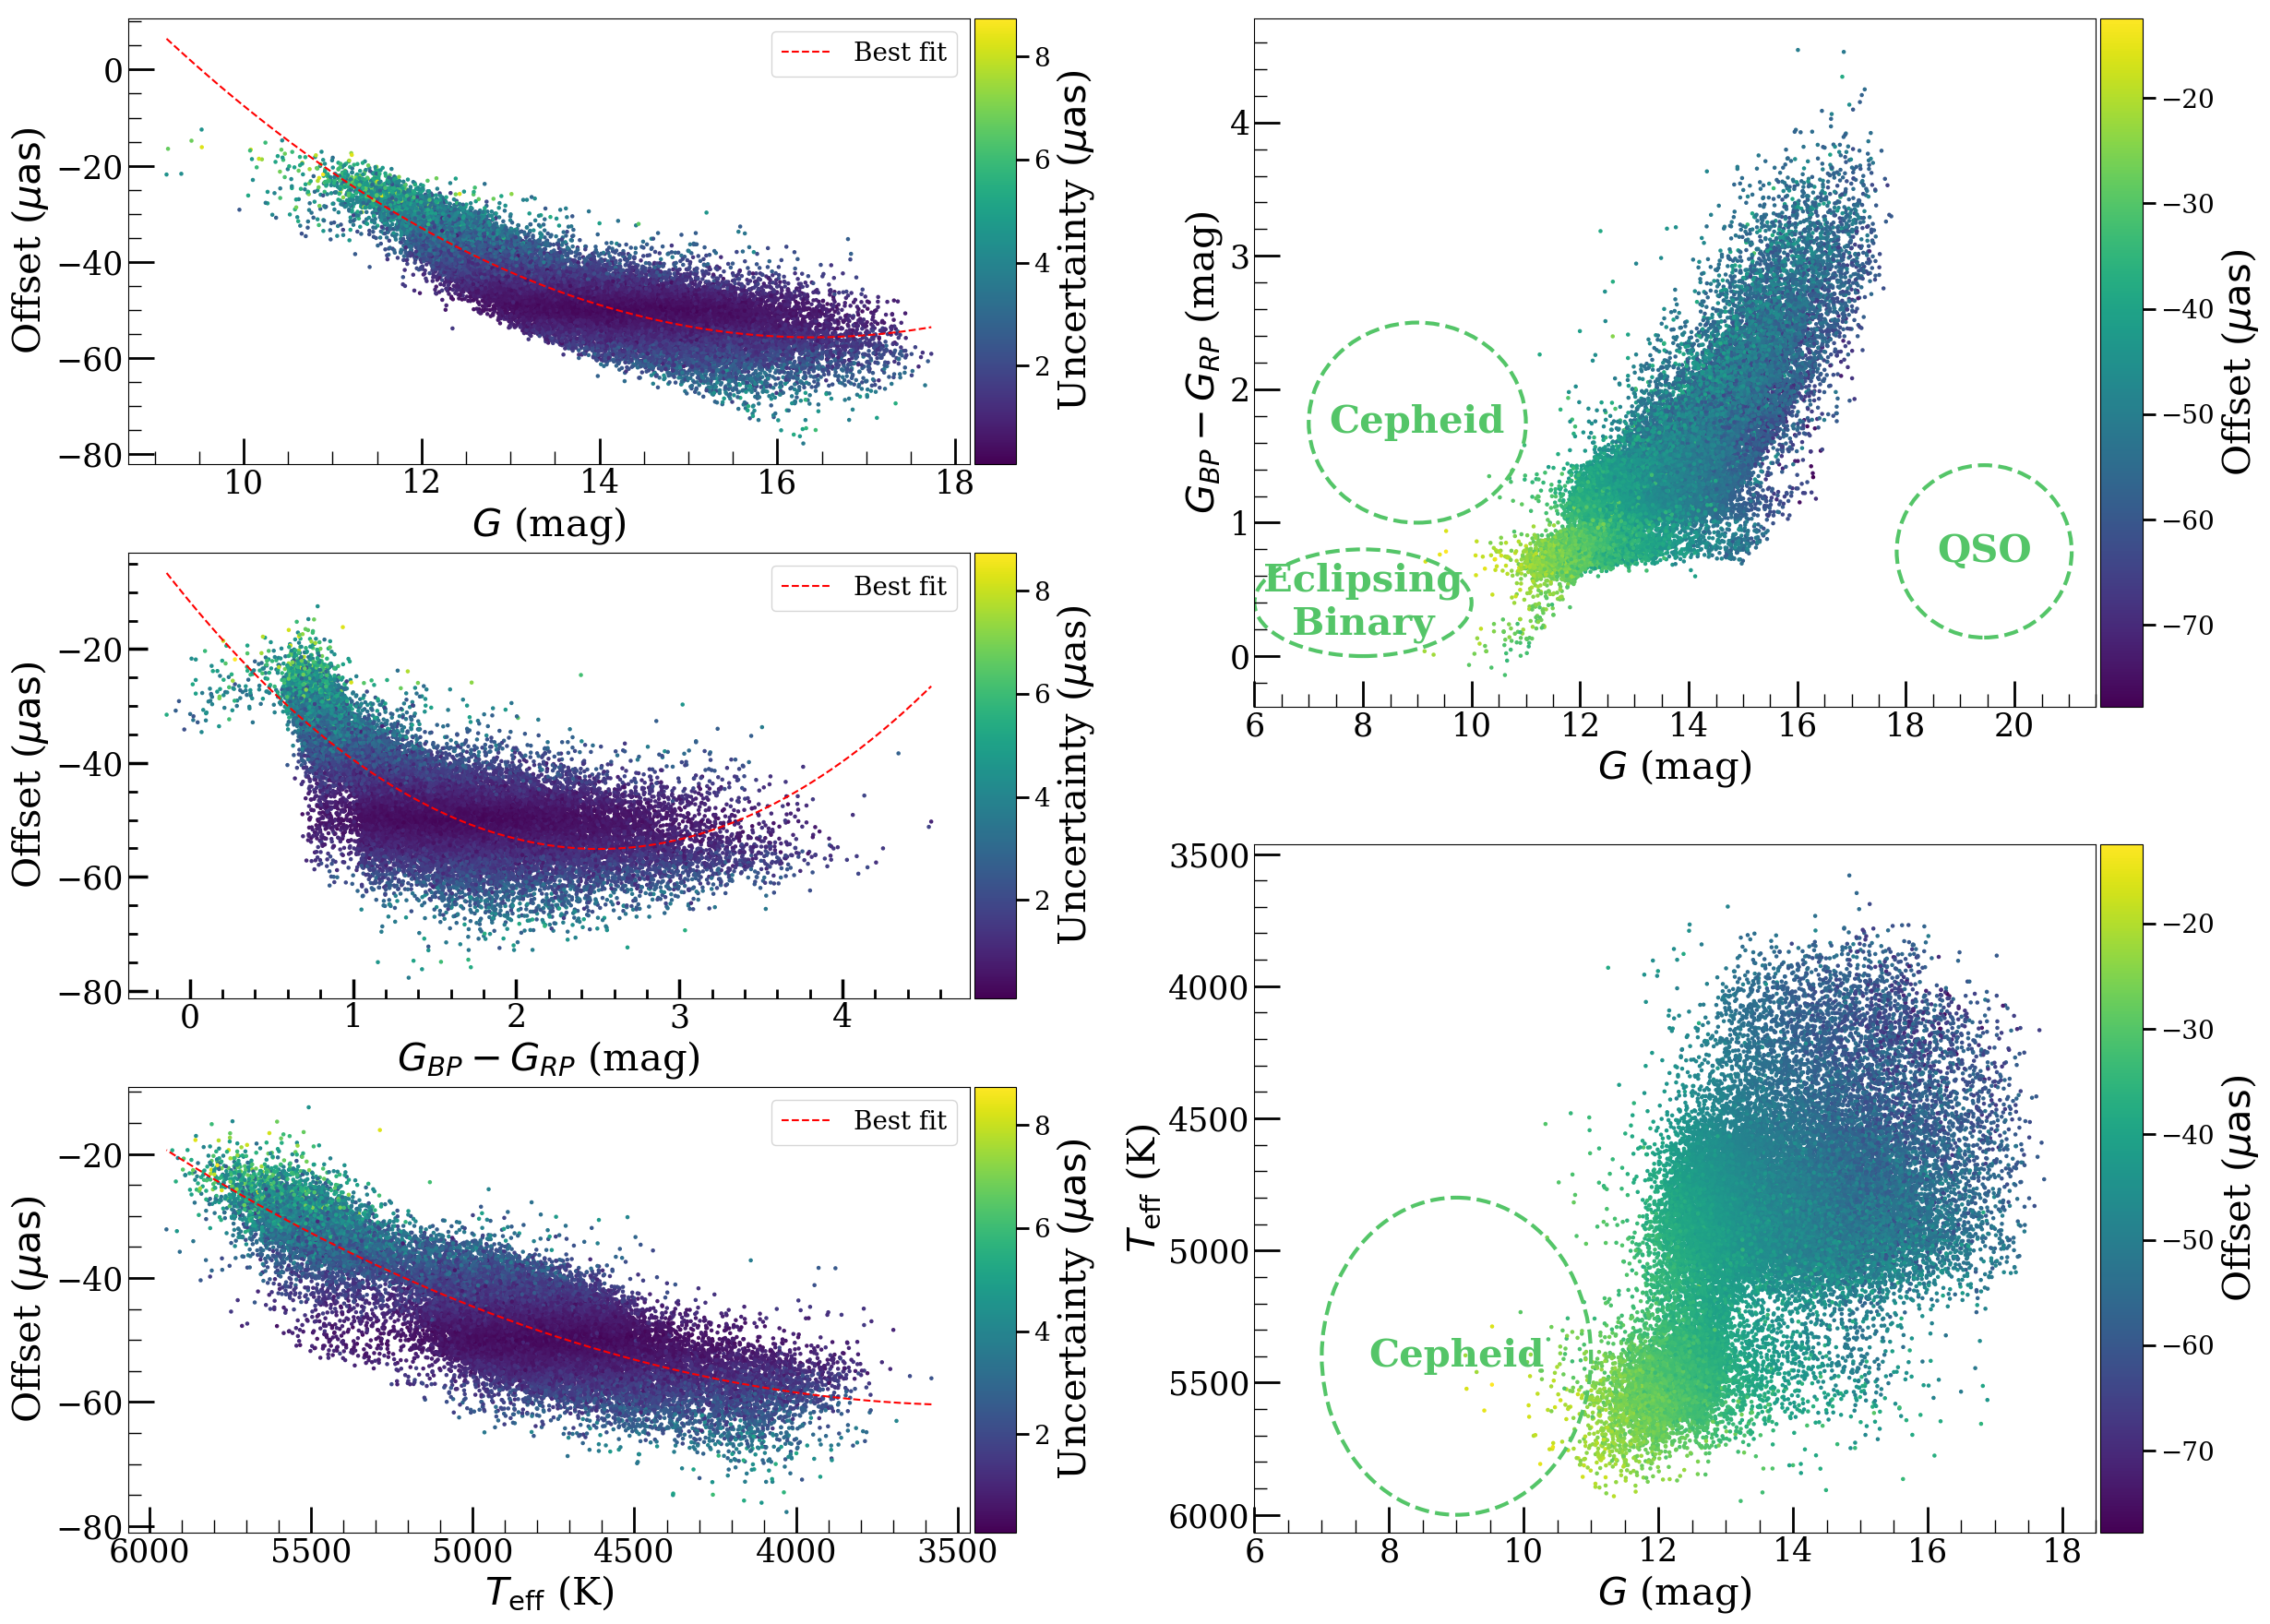

In [1]:
%matplotlib inline
import h5py
import numpy as np
import pylab as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
from matplotlib import patches
import matplotlib

from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

cpu_gpu_check()  # manage GPU memory with astroNN if neccessary, otherwise use CPU
keras = keras_import_manager()  # manage Keras import with astroNN according to astroNN's config.ini
Model = keras.models.Model

net = load_folder("astroNN_multivariate_model")
# create new model to get offset posterior
model = Model(inputs=net.keras_model.input, outputs=net.get_layer("offset_output").output)

with h5py.File('gaia_dr2_test.h5') as F:  # ensure the file will be cleaned up
    bp_rp = np.array(F['bp_rp'])
    phot_g_mean_mag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])

    good_idx = ((bp_rp != -9999.) & (phot_g_mean_mag != -9999.)  & (teff != -9999.))

    bp_rp = bp_rp[good_idx]
    phot_g_mean_mag = phot_g_mean_mag[good_idx]
    teff = teff[good_idx]

# need to manually 
phot_g_mean_mag_std = np.std(phot_g_mean_mag)
phot_g_mean_mag_mean = np.mean(phot_g_mean_mag)
norm_phot_g_mean_mag = (phot_g_mean_mag - phot_g_mean_mag_mean) / phot_g_mean_mag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
norm_bp_rp = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
norm_teff = (teff - teff_mean) / teff_std

aux = np.stack([norm_phot_g_mean_mag, norm_bp_rp, norm_teff]).T

# To get offset posterior, sample 10 times
# 1.412.... is a normalization factor used during training, so here we denormalize it and convert it to uas by *1000
offset = [model.predict({'input': np.expand_dims(np.hstack([np.ones((norm_teff.shape[0], 7515)), aux]), axis=-1), 
                         'labels_err': np.ones((norm_teff.shape[0], 1)), 
                         'input_err': np.ones((norm_teff.shape[0], 7518, 1))}) * 1.4125440212222566 * 1000 for i in range(10)]

# get result and uncertainty by dropout
result, offset_uncertainty = np.mean(offset, axis=0)[:, 0], np.std(offset, axis=0)[:, 0]
z_bp_rp, cov_bp_rp = np.polyfit(bp_rp, result, deg=2, full=False, cov=True)
z_g, cov_g = np.polyfit(phot_g_mean_mag, result, deg=2, full=False, cov=True)
# numpy bug?? need to add 0.5K gaussian to get around teff polyfir error
z_teff, cov_teff = np.polyfit(teff + np.random.normal(0, 0.5, teff.shape), result, deg=2, full=False, cov=True)
p_bp_rp = np.poly1d(z_bp_rp)
p_g = np.poly1d(z_g)
p_teff = np.poly1d(z_teff)

def func(x, a, b, c, d, e, f):
    return a*x[0]**2 + b*x[1]**2 + c*x[0]*x[1] + d*x[0] + e*x[1] + f

# def func(x, a, b, c):
#     return a*x[0] + b*x[1] + c

pall, pall_cov = curve_fit(func, (phot_g_mean_mag, bp_rp), result)

fig = plt.figure(figsize=(25, 18), dpi=100)
gs = gridspec.GridSpec(1, 2)
inner1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0])
inner2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])

ax0 = plt.Subplot(fig, inner1[0])
ax1 = plt.Subplot(fig, inner1[1])
ax2 = plt.Subplot(fig, inner1[2])
ax3 = plt.Subplot(fig, inner2[0])
ax4 = plt.Subplot(fig, inner2[1])

mappable = ax0.scatter(phot_g_mean_mag, result, c=offset_uncertainty, s=5., rasterized=True)
samples = np.linspace(np.min(phot_g_mean_mag), np.max(phot_g_mean_mag), 1000)
ax0.plot(samples, p_g(samples), c='r', ls='--', label='Best fit')
ax0.set_xlabel(r"$G$ (mag)", fontsize=30)
ax0.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax0.minorticks_on()
ax0.tick_params(labelsize=25, width=2, length=20, which='major')
ax0.tick_params(width=1, length=10, which='minor')
ax0.xaxis.set_tick_params(direction='in', which='both')
ax0.yaxis.set_tick_params(direction='in', which='both')
ax0.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu\mathrm{as}$)", size=30)

mappable = ax1.scatter(bp_rp, result, c=offset_uncertainty, s=5., rasterized=True)
samples = np.linspace(np.min(bp_rp), np.max(bp_rp), 1000)
ax1.plot(samples, p_bp_rp(samples), c='r', ls='--', label='Best fit')
ax1.set_xlabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax1.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax1.minorticks_on()
ax1.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax1.tick_params(width=2, length=7, which='minor')
ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax1.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu$as)", size=30)

mappable = ax2.scatter(teff, result, c=offset_uncertainty, s=5., rasterized=True)
samples_norm = np.linspace(np.min(teff), np.max(teff), 1000)
samples = np.linspace(np.min(teff), np.max(teff), 1000)
ax2.plot(samples, p_teff(samples_norm), c='r', ls='--', label='Best fit')
ax2.set_xlabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax2.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax2.minorticks_on()
ax2.tick_params(labelsize=25, width=2, length=20, which='major')
ax2.tick_params(width=1, length=10, which='minor')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')
ax2.invert_xaxis()
ax2.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu\mathrm{as}$)", size=30)

mappable = ax3.scatter(phot_g_mean_mag, bp_rp, c=result, s=5., rasterized=True)
ax3.set_xlabel(r"$G$ (mag)", fontsize=30)
ax3.set_ylabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax3.set_xlim((6, 21.5))
ax3.minorticks_on()
ax3.tick_params(labelsize=25, width=2, length=20, which='major')
ax3.tick_params(width=1, length=10, which='minor')
ax3.xaxis.set_tick_params(direction='in', which='both')
ax3.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu\mathrm{as}$)", size=30)
cc = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=np.min(result), vmax=np.max(result)), cmap=cbar.get_cmap())
# 19.442 [mean of QSO g-mag], 0.785 [mean of QSO bp_rp], 0.806 [std of QSO g-mag], 0.323 [std of QSO bp_rp]
# ADQL command used (https://gea.esac.esa.int/archive/): 
# SELECT phot_g_mean_mag, bp_rp 
# FROM gaiadr2.aux_allwise_agn_gdr2_cross_id AS agn, gaiadr2.gaia_source AS gaia 
# WHERE agn.source_id = gaia.source_id
circle1 = patches.Ellipse((19.442, 0.785), 0.806*4, 0.323*4, angle=0, ec=cc.to_rgba(-30), lw='3.', fc='none', ls='--')
ax3.add_artist(circle1)
ax3.annotate("QSO", (19.442, 0.785), color=cc.to_rgba(-30), fontsize=30, ha="center", va="center", weight='bold')
circle2 = patches.Ellipse((9, 1.75), 2*2, 0.75*2, angle=0, ec=cc.to_rgba(-30), lw='3.', fc='none', ls='--')
ax3.add_artist(circle2)
ax3.annotate("Cepheid", (9, 1.75), color=cc.to_rgba(-30), fontsize=30, ha="center", va="center", weight='bold')
circle3 = patches.Ellipse((8, 0.4), 2*2, 0.4*2, angle=0, ec=cc.to_rgba(-30), lw='3.', fc='none', ls='--')
ax3.add_artist(circle3)
ax3.annotate("Eclipsing\nBinary", (8, 0.4), color=cc.to_rgba(-30), fontsize=30, ha="center", va="center", weight='bold')

mappable = ax4.scatter(phot_g_mean_mag, teff, c=result, s=5., rasterized=True)
ax4.set_xlabel(r"$G$ (mag)", fontsize=30)
ax4.set_ylabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax4.set_xlim((6, 18.5))
ax4.minorticks_on()
ax4.tick_params(labelsize=25, width=2, length=20, which='major')
ax4.tick_params(width=1, length=10, which='minor')
ax4.xaxis.set_tick_params(direction='in', which='both')
ax4.yaxis.set_tick_params(direction='in', which='both')
ax4.invert_yaxis()
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu\mathrm{as}$)", size=30)
circle3 = patches.Ellipse((9, 5400), 2*2, 1200, angle=0, ec=cc.to_rgba(-30), lw='3.', fc='none', ls='--')
ax4.add_artist(circle3)
ax4.annotate("Cepheid", (9, 5400), color=cc.to_rgba(-30), fontsize=30, ha="center", va="center", weight='bold')

fig.add_subplot(ax0)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
fig.add_subplot(ax3)
fig.add_subplot(ax4)

fig.tight_layout()
plt.savefig("result_offset.pdf")

print("G mag: ", z_g, np.diag(cov_g))
print("DP_RP: ", z_bp_rp, np.diag(cov_bp_rp))
print("T_eff: ", z_teff, np.diag(cov_teff))

print("\nPlane fit parameter: ", pall)
print("Parameter uncertainty: ", np.diag(pall_cov))

In [2]:
z_bp_rp, cov_bp_rp = np.polyfit(bp_rp, result, deg=2, full=False, cov=True)
z_g, cov_g = np.polyfit(phot_g_mean_mag-16, result, deg=2, full=False, cov=True)
# numpy bug?? need to add 0.5K gaussian to get around teff polyfir error
z_teff, cov_teff = np.polyfit(teff + np.random.normal(0, 0.5, teff.shape) -4500, result, deg=2, full=False, cov=True)
p_bp_rp = np.poly1d(z_bp_rp)
p_g = np.poly1d(z_g)
p_teff = np.poly1d(z_teff)
print("G mag: ", z_g, np.diag(cov_g))
print("DP_RP: ", z_bp_rp, np.diag(cov_bp_rp))
print("T_eff: ", z_teff, np.diag(cov_teff))

G mag:  [  1.17917354  -0.92191425 -55.49193842] [0.00016604 0.00320219 0.00360154]
DP_RP:  [  6.90437316 -34.63538057 -11.6736862 ] [0.00398715 0.05321488 0.03645931]
T_eff:  [ 6.55184023e-06  1.38623994e-02 -5.31695606e+01] [1.70196426e-14 1.62372951e-08 1.52182792e-03]


In [5]:
z_g2, cov_g = np.polyfit(phot_g_mean_mag-16, result, deg=2, w=1/offset_uncertainty, full=False, cov=True)
print(z_g2)
# numpy bug?? need to add 0.5K gaussian to get around teff polyfir error
z_teff2, cov_teff = np.polyfit(teff + np.random.normal(0, 0.5, teff.shape)-4500, result, deg=2, w=1/offset_uncertainty, full=False, cov=True)
print(z_teff2)

pall2, pall_cov2 = curve_fit(func, (phot_g_mean_mag-16, bp_rp), result, 
                             sigma=offset_uncertainty, absolute_sigma=True)
print(pall2)

[  0.9211908    0.76511713 -51.57631069]
[ 5.82437469e-06  4.61276765e-03 -5.13747425e+01]
[ -0.08405161  -1.77154082   3.27577325  -8.3110656   11.47467045
 -68.89110033]


Sandard Dv:  5.617553261517918


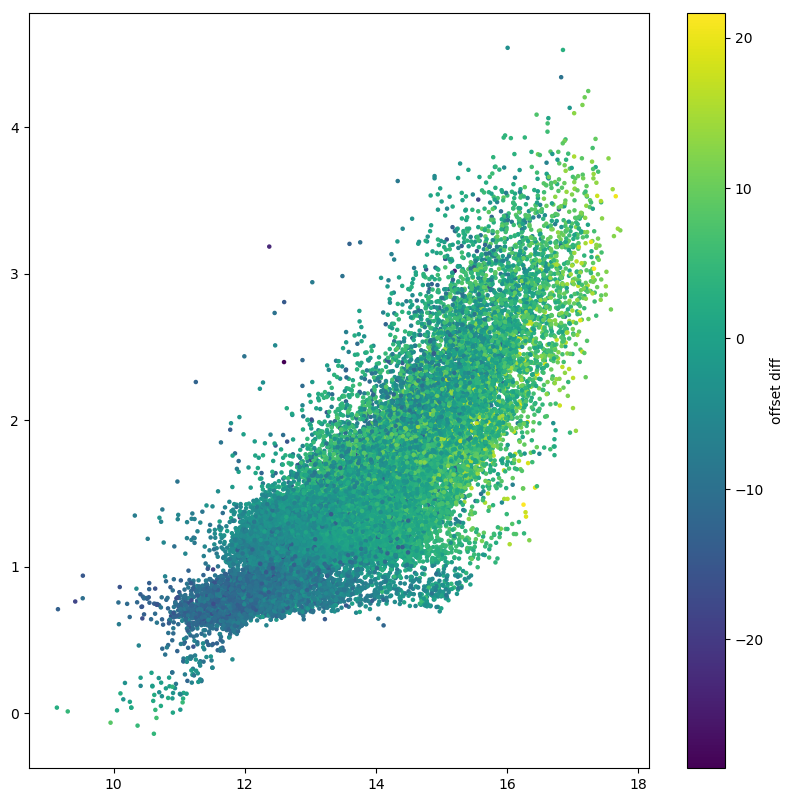

In [2]:
%matplotlib inline
import pylab as plt
import numpy as np
import h5py

with h5py.File('gaia_dr2_test.h5') as F:  # ensure the file will be cleaned up
    bp_rp = np.array(F['bp_rp'])
    phot_g_mean_mag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])

    good_idx = ((bp_rp != -9999.) & (phot_g_mean_mag != -9999.)  & (teff != -9999.))

    bp_rp = bp_rp[good_idx]
    phot_g_mean_mag = phot_g_mean_mag[good_idx]
    teff = teff[good_idx]

# need to manually 
phot_g_mean_mag_std = np.std(phot_g_mean_mag)
phot_g_mean_mag_mean = np.mean(phot_g_mean_mag)
norm_phot_g_mean_mag = (phot_g_mean_mag - phot_g_mean_mag_mean) / phot_g_mean_mag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
norm_bp_rp = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
norm_teff = (teff - teff_mean) / teff_std

fig = plt.figure(figsize=(10, 10), dpi=100)
plt.scatter(phot_g_mean_mag, bp_rp, c=func([phot_g_mean_mag, bp_rp], *pall) - result, s=5.)
cbar = plt.colorbar()
cbar.set_label("offset diff")

print("Sandard Dv: ", np.std(func([phot_g_mean_mag, bp_rp], *pall) - result))

# Comparison between with and without offset model

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 116.91s elapsed
Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNN
Starting Dropout Variational Inference
Completed Dropout Variational Inference with 100 forward passes, 115.05s elapsed


C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Henry\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


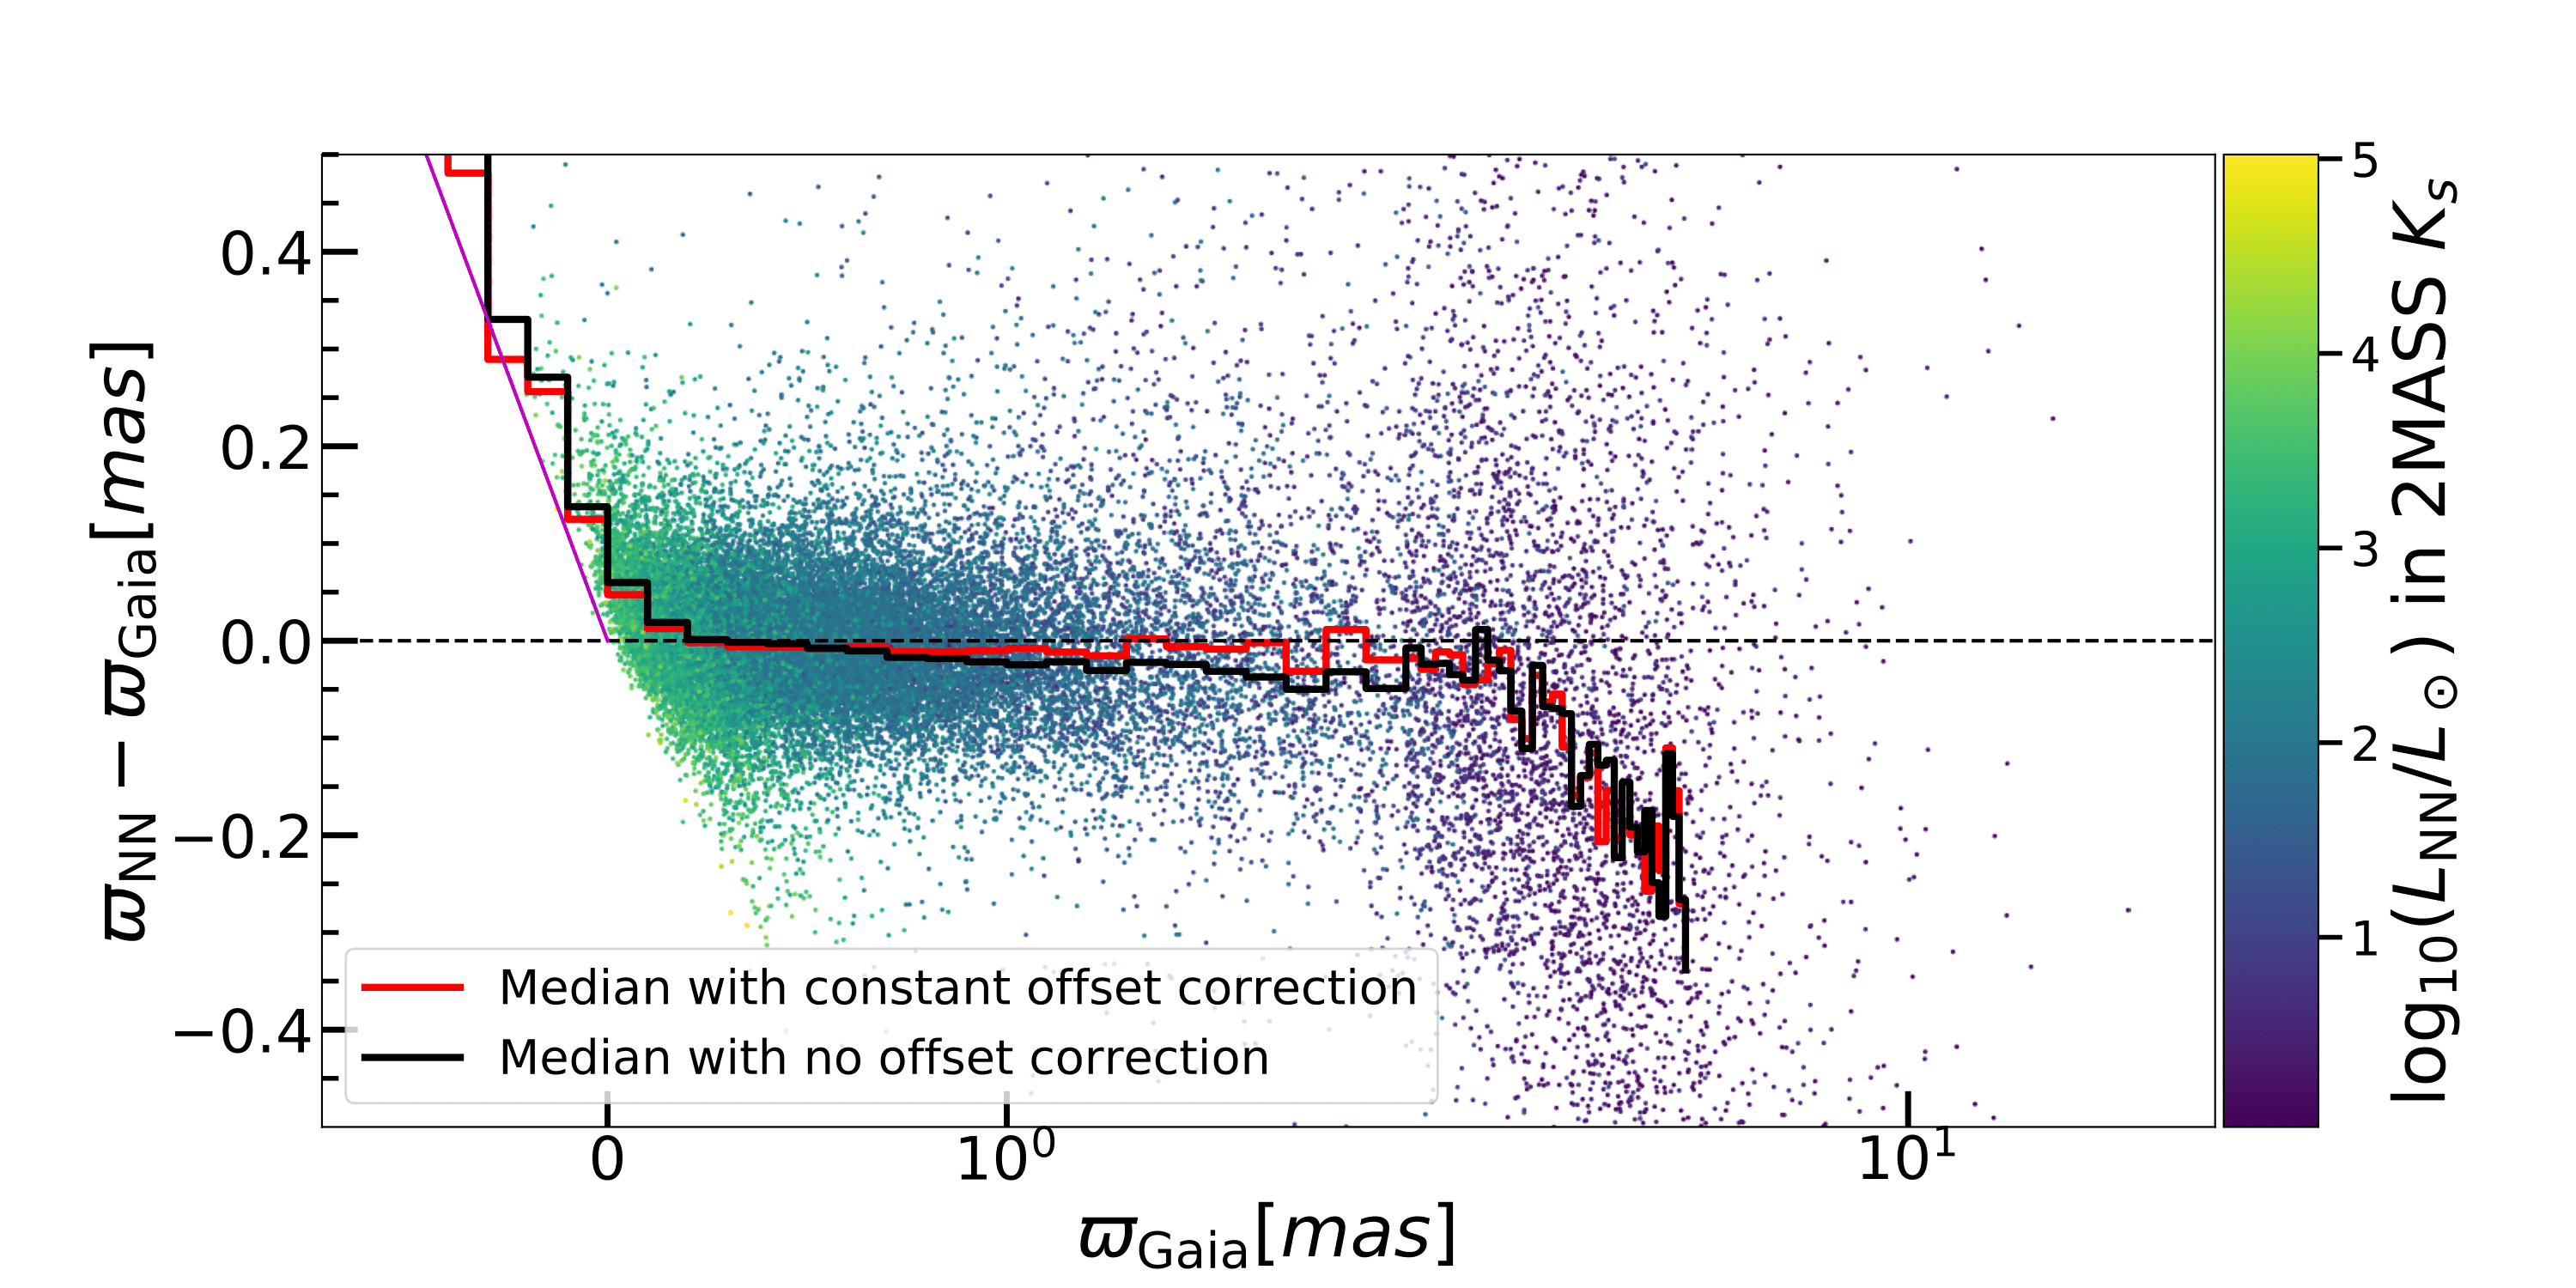

In [1]:
%matplotlib inline
from astroNN.models import load_folder
from astroNN.nn.numpy import median_absolute_percentage_error as mape
from astroNN.gaia import mag_to_fakemag, fakemag_to_pc, fakemag_to_logsol, fakemag_to_parallax
import h5py
import numpy as np
import pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

with h5py.File('gaia_dr2_test.h5', 'r') as F:
    spectra = np.array(F['spectra'])
    parallax = np.array(F['parallax'])
    parallax_err = np.array(F['parallax_err'])
    corrected_K = np.array(F['corrected_K'])
    
net = load_folder("astroNN_constant_model_reduced")
pred, pred_error = net.test(spectra)

net2 = load_folder("astroNN_no_offset_model")
pred2, pred2_error = net2.test(spectra)

logsol = fakemag_to_logsol(pred[:, 0])

above_solar = (logsol > 0)

number_bin = 55
low_parallax = -0.5
high_parallax= 5
median_diff = []
median_diff2 = []
spaces_dist = np.linspace(low_parallax, high_parallax, number_bin+1)

residue = (fakemag_to_parallax(pred[:, 0], corrected_K).value - parallax - 0.052)[above_solar]
residue2 = (fakemag_to_parallax(pred2[:, 0], corrected_K).value - parallax)[above_solar]

for i in range(number_bin):
    idx = ((parallax[above_solar]<spaces_dist[i+1]) & (parallax[above_solar]>spaces_dist[i]))
    median_diff.append(np.median(residue[idx]))
    median_diff2.append(np.median(residue2[idx]))

f, ax = plt.subplots(1, figsize=(15,7.5), dpi=100)
ax.semilogx(spaces_dist[:-1], np.array(median_diff), ls='steps-post', linewidth=3., c='r', label='Median with constant offset correction')
ax.semilogx(spaces_dist[:-1], np.array(median_diff2), ls='steps-post', linewidth=3., c='k', label='Median with no offset correction')
mappable = ax.scatter(parallax[above_solar], residue, c=logsol[above_solar], s=1., rasterized=True)
ax.set_xscale('symlog')
ax.axhline(0., ls='--', c='k')
ax.plot([0, -0.5], [0.0, 0.55], c='m')
ax.set_xlabel(r'$ \varpi_{\mathrm{Gaia}} [mas]$', fontsize=30)
ax.set_ylabel(r'$\varpi_{\mathrm{NN}} - \varpi_{\mathrm{Gaia}} [$\mathrm{mas}$]$', fontsize=30)
ax.set_ylim(-0.5, 0.5)
ax.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"$\log_{10} (L_\mathrm{NN} /L_\odot)$" + " in 2MASS " + r"$K_{s}$", size=30)
ax.minorticks_on()
ax.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax.tick_params(width=1, length=7, which='minor')
ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')
# plt.savefig("result_offset_median.pdf")

## Constant Offset model v.s. Multivariate Offset model Comparison

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN


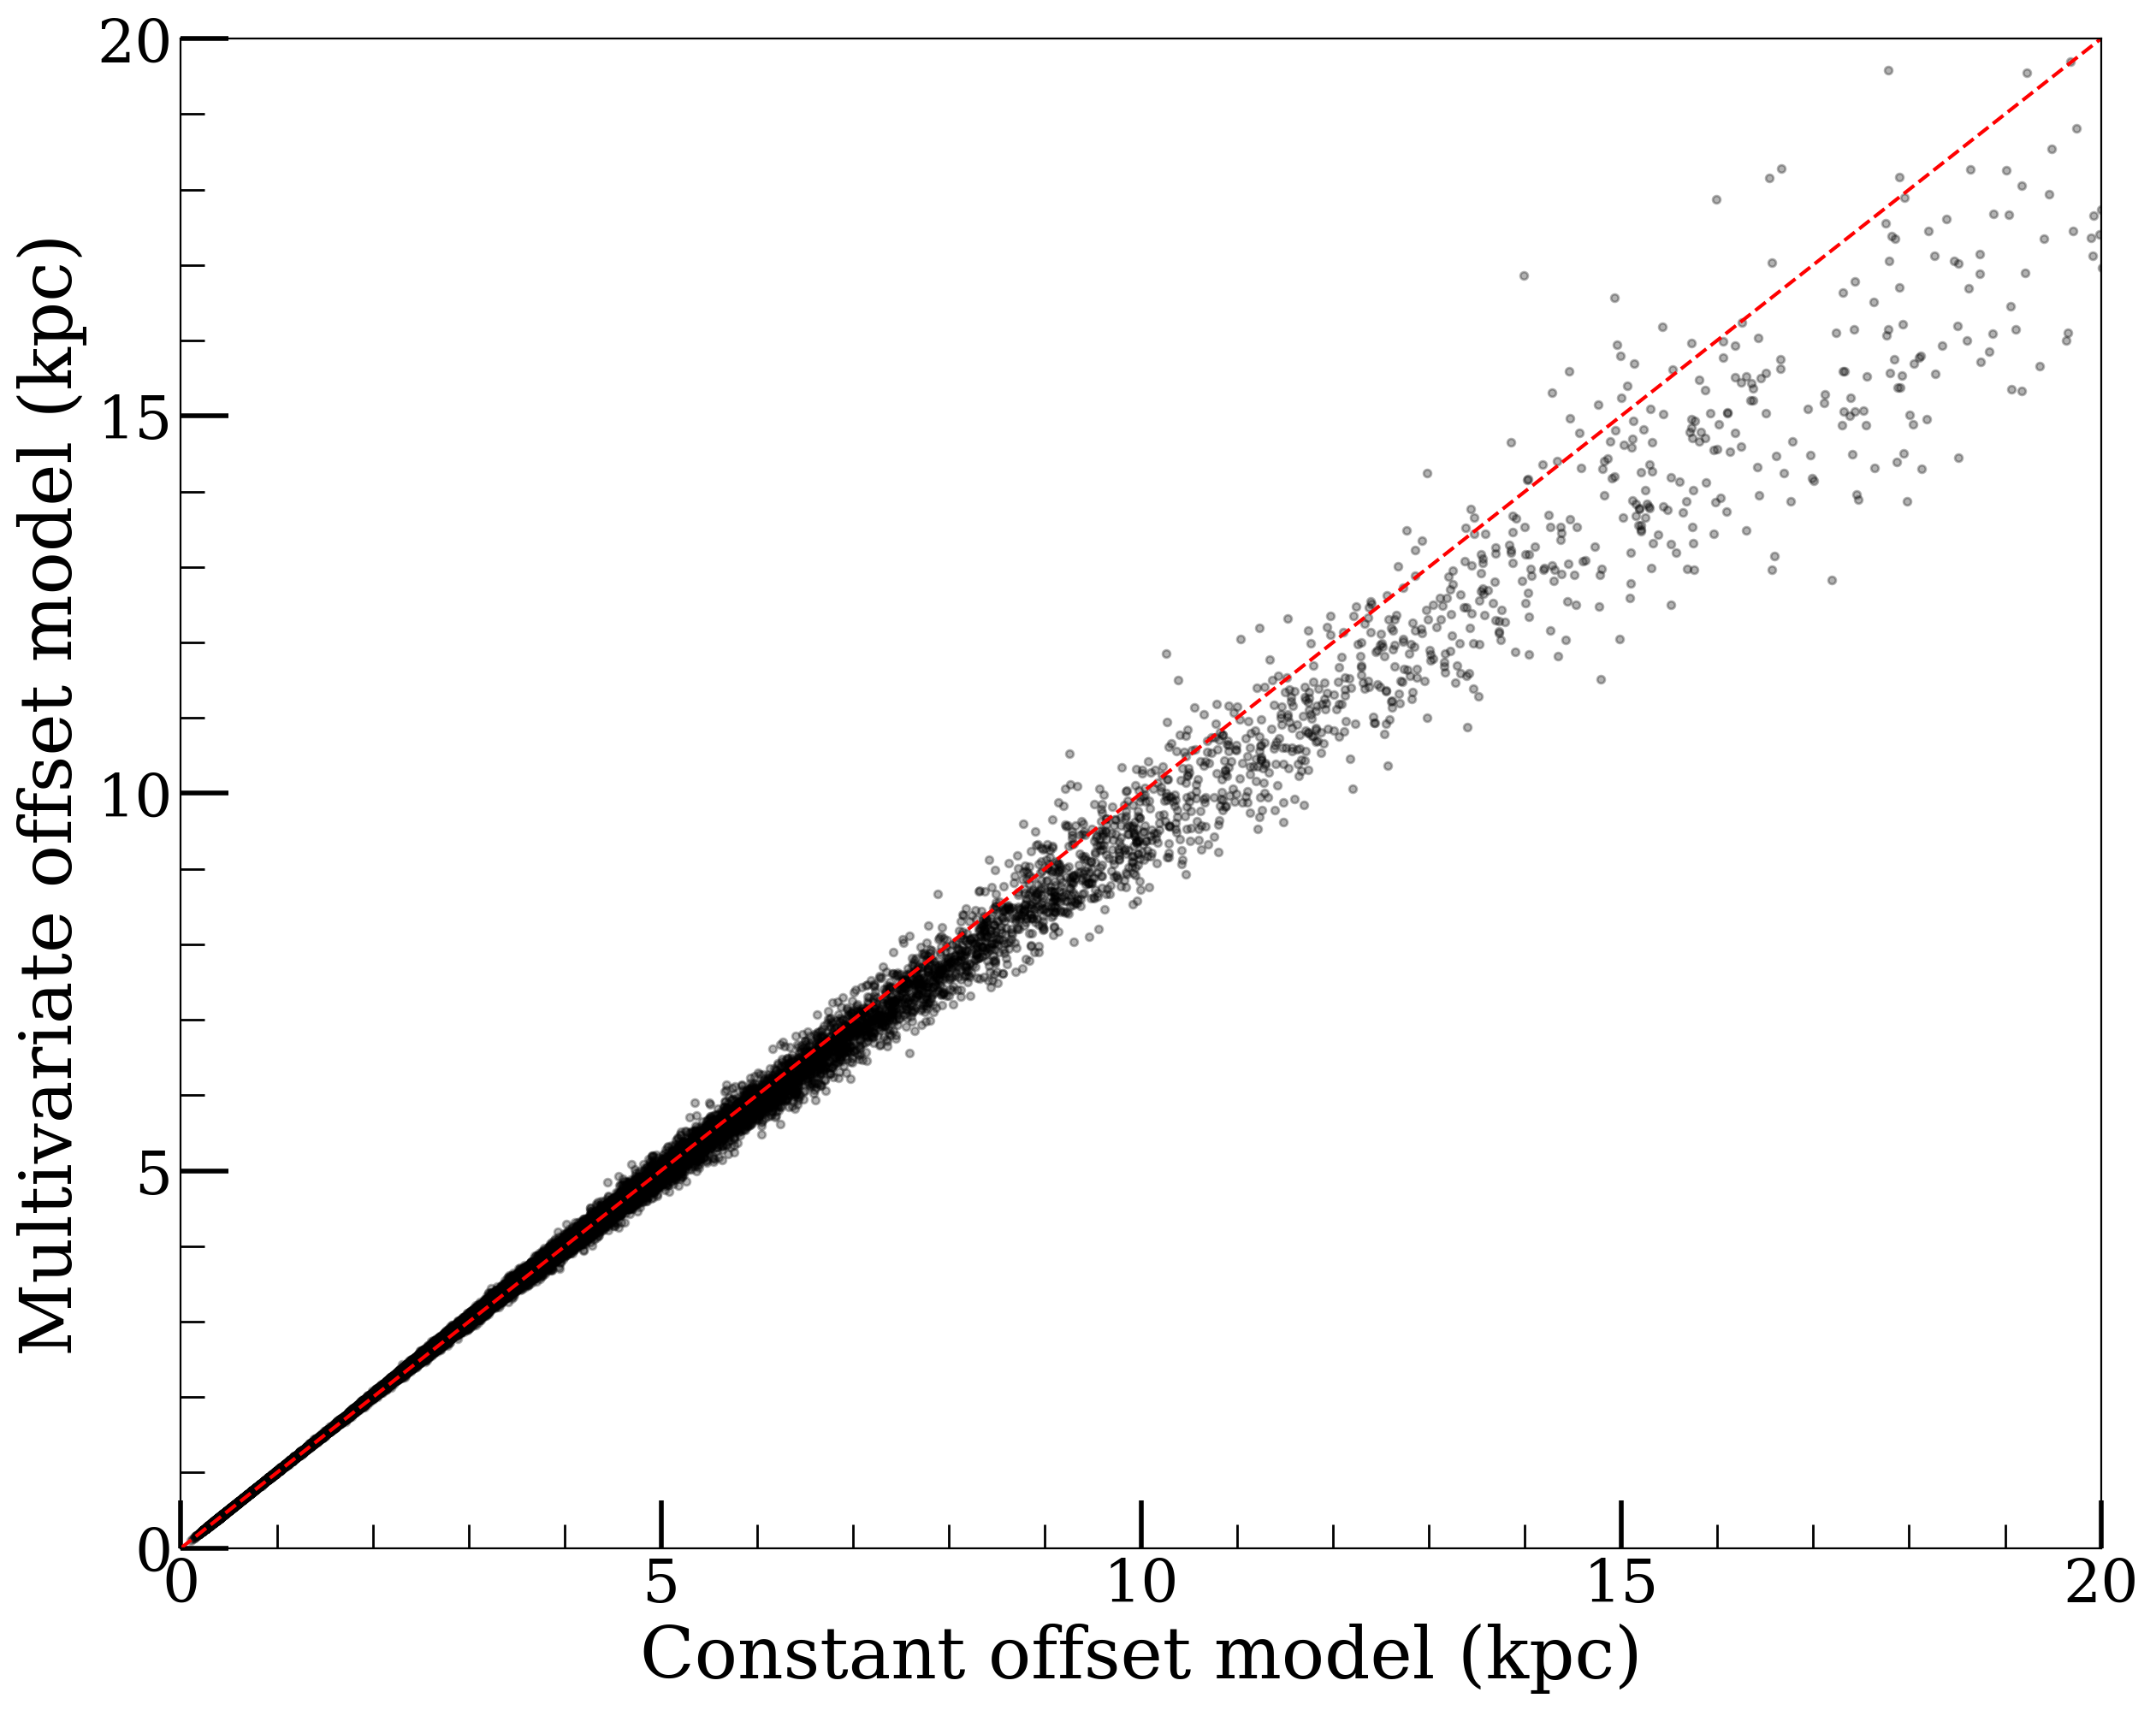

In [3]:
%matplotlib inline
import h5py
import numpy as np
import pylab as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

cpu_gpu_check()  # manage GPU memory with astroNN if neccessary, otherwise use CPU
keras = keras_import_manager()  # manage Keras import with astroNN according to astroNN's config.ini
Model = keras.models.Model

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

net = load_folder("astroNN_multivariate_model")
# create new model to get offset posterior
model = Model(inputs=net.keras_model.input, outputs=net.get_layer("offset_output").output)

with h5py.File('gaia_dr2_test.h5') as F:  # ensure the file will be cleaned up
    bp_rp = np.array(F['bp_rp'])
    phot_g_mean_mag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])
    parallax = np.array(F['parallax'])

    good_idx = ((bp_rp != -9999.) & (phot_g_mean_mag != -9999.)  & (teff != -9999.))

    bp_rp = bp_rp[good_idx]
    phot_g_mean_mag = phot_g_mean_mag[good_idx]
    teff = teff[good_idx]
    parallax = parallax[good_idx]
    
# need to manually 
phot_g_mean_mag_std = np.std(phot_g_mean_mag)
phot_g_mean_mag_mean = np.mean(phot_g_mean_mag)
norm_phot_g_mean_mag = (phot_g_mean_mag - phot_g_mean_mag_mean) / phot_g_mean_mag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
norm_bp_rp = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
norm_teff = (teff - teff_mean) / teff_std

aux = np.stack([norm_phot_g_mean_mag, norm_bp_rp, norm_teff]).T

# To get offset posterior, sample 10 times
# 1.412.... is a normalization factor used during training, so here we denormalize it and convert it to uas by *1000
offset = [model.predict({'input': np.expand_dims(np.hstack([np.ones((norm_teff.shape[0], 7515)), aux]), axis=-1), 
                         'labels_err': np.ones((norm_teff.shape[0], 1)), 
                         'input_err': np.ones((norm_teff.shape[0], 7518, 1))}) * 1.4125440212222566 * 1000 for i in range(10)]

# get result and uncertainty by dropout
result, offset_uncertainty = np.mean(offset, axis=0)[:, 0], np.std(offset, axis=0)[:, 0]

constant_offset = parallax - (-0.052)
multivariate_offset = parallax - (result/1000)

fig, ax = plt.subplots(figsize=(13, 10.4), dpi=200)
ax.scatter(1 / constant_offset, 1 / multivariate_offset, s=10., c='k', alpha=0.3, rasterized=True)
ax.plot([0, 20], [0, 20], 'r--')
ax.set_xlabel('Constant offset model (kpc)', fontsize=30)
ax.set_ylabel('Multivariate offset model (kpc)', fontsize=30)
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.minorticks_on()
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_yticks([0, 5, 10, 15, 20])
ax.tick_params(labelsize=25, width=2, length=20, which='major')
ax.tick_params(width=1, length=10, which='minor')
ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')
fig.tight_layout()
fig.savefig("offset_comparison.pdf")

## Gaia offset for APOGEE RC

Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeDR14GaiaDR2BCNN
E:\sdss_mirror\dr14/apogee/vac/apogee-rc/cat/apogee-rc-DR14.fits was found!
G mag:  [  0.44034218 -13.76796006  58.84510481] [1.26703407e-04 9.01882850e-02 3.94460828e+00]
DP_RP:  [  4.08464027 -18.08990826 -27.50786328] [0.01721128 0.28143056 0.2547063 ]
T_eff:  [-1.08127261e-05  1.38524852e-01 -4.61753388e+02] [1.58844195e-12 1.46288337e-04 8.41210147e+02]

Plane fit parameter:  [ 0.33524856  1.05477061 -0.37540867 -9.63192136  2.45379448 21.30501749]
Parameter uncertainty:  [1.78193557e-05 1.74345589e-03 6.00683153e-04 7.49678042e-03
 5.75039640e-02 2.36120321e-01]


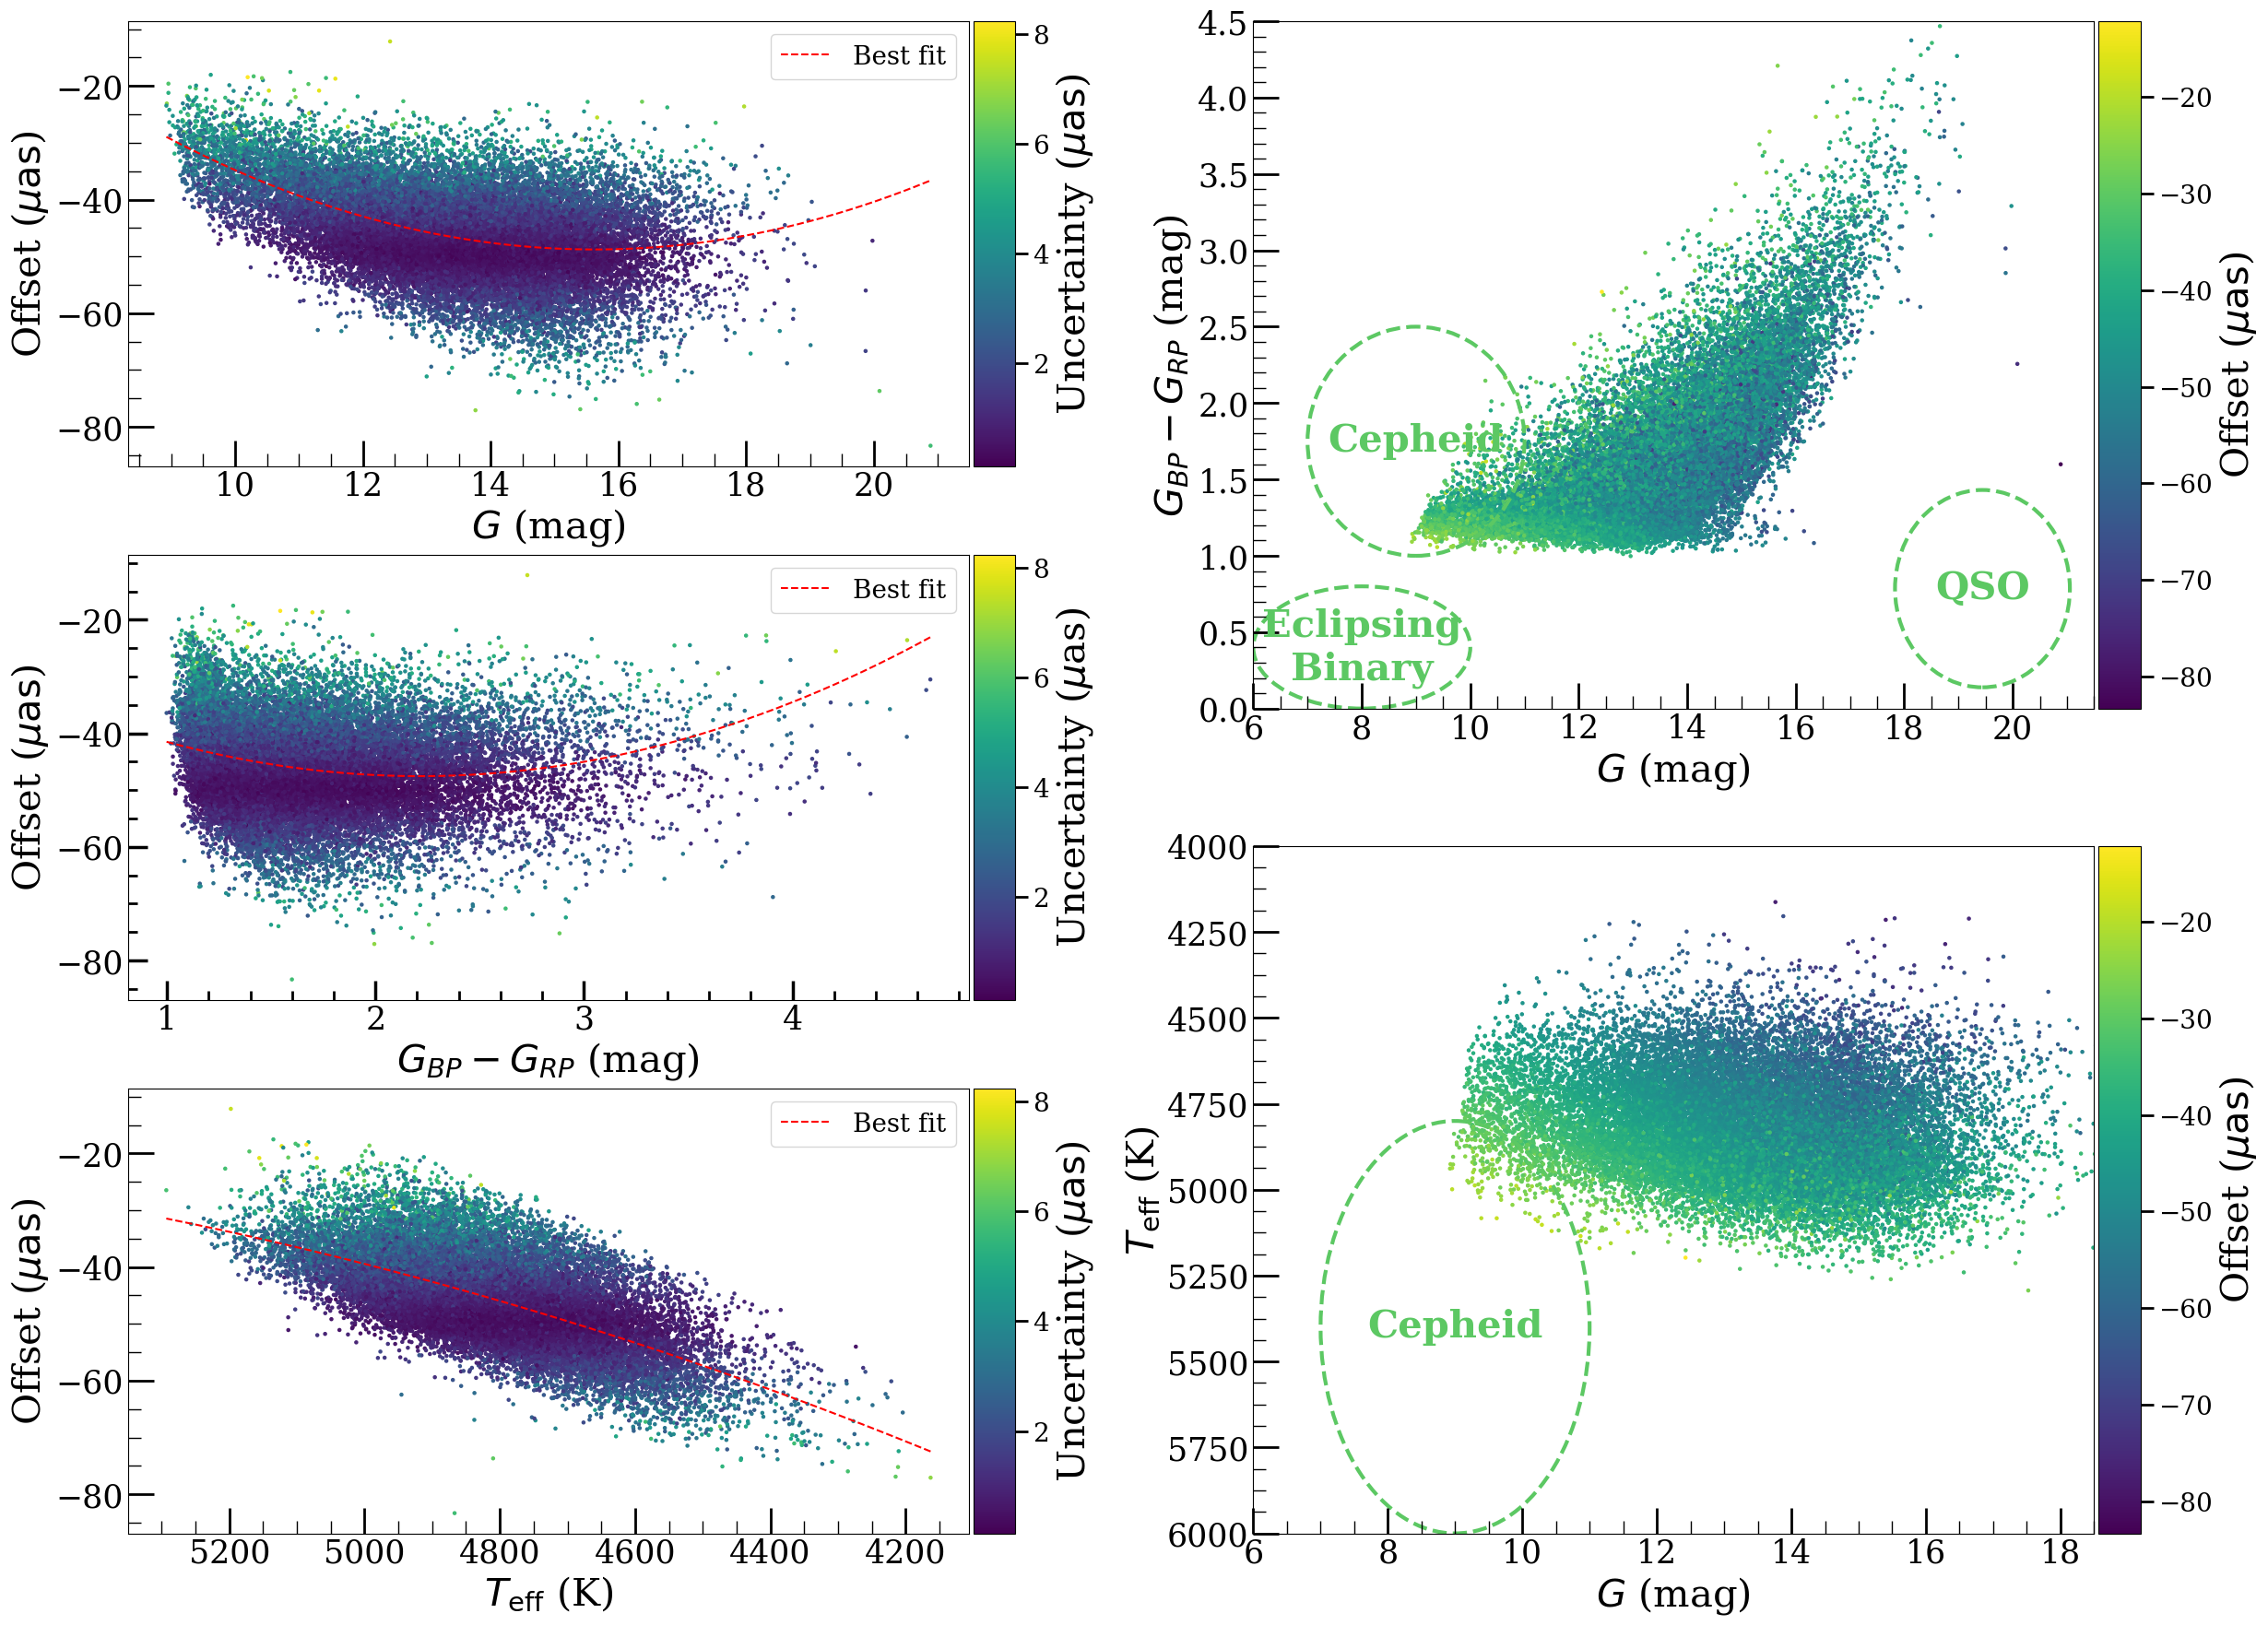

In [3]:
%matplotlib inline
import numpy as np
import pylab as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter
from matplotlib import patches
import matplotlib

from astropy.io import fits
from astropy.stats import mad_std

from astroNN.nn.numpy import median_absolute_percentage_error
from astroNN.apogee import allstar
from astroNN.datasets import xmatch
from astroNN.datasets import load_apogee_distances, load_apogee_rc
from astroNN.models import load_folder
from astroNN.config import keras_import_manager, cpu_gpu_check

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

cpu_gpu_check()  # manage GPU memory with astroNN if neccessary, otherwise use CPU
keras = keras_import_manager()  # manage Keras import with astroNN according to astroNN's config.ini
Model = keras.models.Model

net = load_folder("astroNN_multivariate_model")
# create new model to get offset posterior
model = Model(inputs=net.keras_model.input, outputs=net.get_layer("offset_output").output)

gaia_data_file = fits.getdata("apogeedr14_gaiadr2_xmatch.fits")
bp_rp=gaia_data_file['bp_rp']
phot_g_mean_mag=gaia_data_file['phot_g_mean_mag']

astroNN_data = fits.getdata("apogee_dr14_nn_dist.fits")
apogee_id = astroNN_data['APOGEE_ID']
ra = astroNN_data['RA']
dec = astroNN_data['DEC']
astroNN_pc = astroNN_data['dist']
astroNN_pc_error = astroNN_data['dist_error']
good_idx = ((astroNN_pc_error!=-9999.) & (astroNN_pc / astroNN_pc_error > 5) & (phot_g_mean_mag!=-9999.) & (bp_rp!=-9999.))

astroNN_teff = teff = fits.getdata("astroNN_apogee_dr14_catalog.fits")['astroNN'][:, 0][good_idx]
astroNN_logg = fits.getdata("astroNN_apogee_dr14_catalog.fits")['astroNN'][:, 1][good_idx]

# red clumps
rc_RA, rc_DEC, rc_pc = load_apogee_rc(dr=14, metric='distance')
non_rc_ra = np.genfromtxt("apogee_non_rc_ra.txt")  # RC contemination from NN logg comparison
ele, idx1, idx2 = np.intersect1d(non_rc_ra, rc_RA, return_indices=True)  # cross-match
rc_RA = np.delete(rc_RA, idx2)
rc_DEC = np.delete(rc_DEC, idx2)
rc_pc = np.delete(rc_pc, idx2)
idx5, idx6, sep = xmatch(ra[good_idx], rc_RA, colRA1=ra[good_idx], colDec1=dec[good_idx], colRA2=rc_RA, colDec2=rc_DEC, swap=False)

astroNN_teff = astroNN_teff[idx5]
teff = teff[idx5]
bp_rp=gaia_data_file['bp_rp'][good_idx][idx5]
phot_g_mean_mag=gaia_data_file['phot_g_mean_mag'][good_idx][idx5]

# need to manually 
phot_g_mean_mag_std = np.std(phot_g_mean_mag)
phot_g_mean_mag_mean = np.mean(phot_g_mean_mag)
norm_phot_g_mean_mag = (phot_g_mean_mag - phot_g_mean_mag_mean) / phot_g_mean_mag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
norm_bp_rp = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
norm_teff = (teff - teff_mean) / teff_std

aux = np.stack([norm_phot_g_mean_mag, norm_bp_rp, norm_teff]).T

offset = [model.predict({'input': np.expand_dims(np.hstack([np.ones((norm_teff.shape[0], 7515)), aux]), axis=-1), 
                         'labels_err': np.ones((norm_teff.shape[0], 1)), 
                         'input_err': np.ones((norm_teff.shape[0], 7518, 1))}) * 1.4125440212222566 * 1000 for i in range(10)]
# get result and uncertainty by dropout
result, offset_uncertainty = np.mean(offset, axis=0)[:, 0], np.std(offset, axis=0)[:, 0]
z_bp_rp, cov_bp_rp = np.polyfit(bp_rp, result, deg=2, full=False, cov=True)
z_g, cov_g = np.polyfit(phot_g_mean_mag, result, deg=2, full=False, cov=True)
# numpy bug?? need to add 0.5K gaussian to get around teff
z_teff, cov_teff = np.polyfit(teff + np.random.normal(0, 0.5, teff.shape), result, deg=2, full=False, cov=True)
p_bp_rp = np.poly1d(z_bp_rp)
p_g = np.poly1d(z_g)
p_teff = np.poly1d(z_teff)

def func(x, a, b, c, d, e, f):
    return a*x[0]**2 + b*x[1]**2 + c*x[0]*x[1] + d*x[0] + e*x[1] + f

pall, pall_cov = curve_fit(func, (phot_g_mean_mag, bp_rp), result, 
                           sigma=offset_uncertainty, absolute_sigma=True)

fig = plt.figure(figsize=(25, 18), dpi=100)
gs = gridspec.GridSpec(1, 2)
inner1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0])
inner2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])

ax0 = plt.Subplot(fig, inner1[0])
ax1 = plt.Subplot(fig, inner1[1])
ax2 = plt.Subplot(fig, inner1[2])
ax3 = plt.Subplot(fig, inner2[0])
ax4 = plt.Subplot(fig, inner2[1])

mappable = ax0.scatter(phot_g_mean_mag, result, c=offset_uncertainty, s=5., rasterized=True)
samples = np.linspace(np.min(phot_g_mean_mag), np.max(phot_g_mean_mag), 1000)
ax0.plot(samples, p_g(samples), c='r', ls='--', label='Best fit')
ax0.set_xlabel(r"$G$ (mag)", fontsize=30)
ax0.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax0.minorticks_on()
ax0.tick_params(labelsize=25, width=2, length=20, which='major')
ax0.tick_params(width=1, length=10, which='minor')
ax0.xaxis.set_tick_params(direction='in', which='both')
ax0.yaxis.set_tick_params(direction='in', which='both')
ax0.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu\mathrm{as}$)", size=30)

mappable = ax1.scatter(bp_rp, result, c=offset_uncertainty, s=5., rasterized=True)
samples = np.linspace(np.min(bp_rp), np.max(bp_rp), 1000)
ax1.plot(samples, p_bp_rp(samples), c='r', ls='--', label='Best fit')
ax1.set_xlabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax1.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax1.minorticks_on()
ax1.tick_params(labelsize=25, width=2.5, length=15, which='major')
ax1.tick_params(width=2, length=7, which='minor')
ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax1.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu$as)", size=30)

mappable = ax2.scatter(teff, result, c=offset_uncertainty, s=5., rasterized=True)
samples_norm = np.linspace(np.min(teff), np.max(teff), 1000)
samples = np.linspace(np.min(teff), np.max(teff), 1000)
ax2.plot(samples, p_teff(samples_norm), c='r', ls='--', label='Best fit')
ax2.set_xlabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax2.set_ylabel(r"Offset ($\mu\mathrm{as}$)", fontsize=30)
ax2.minorticks_on()
ax2.tick_params(labelsize=25, width=2, length=20, which='major')
ax2.tick_params(width=1, length=10, which='minor')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')
ax2.invert_xaxis()
ax2.legend(loc='best', fontsize=20)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Uncertainty ($\mu\mathrm{as}$)", size=30)

mappable = ax3.scatter(phot_g_mean_mag, bp_rp, c=result, s=5., rasterized=True)
ax3.set_xlabel(r"$G$ (mag)", fontsize=30)
ax3.set_ylabel(r"$G_{BP}-G_{RP}$ (mag)", fontsize=30)
ax3.set_xlim((6, 21.5))
ax3.set_ylim((0, 4.5))

ax3.minorticks_on()
ax3.tick_params(labelsize=25, width=2, length=20, which='major')
ax3.tick_params(width=1, length=10, which='minor')
ax3.xaxis.set_tick_params(direction='in', which='both')
ax3.yaxis.set_tick_params(direction='in', which='both')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu\mathrm{as}$)", size=30)
cc = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=np.min(result), vmax=np.max(result)), cmap=cbar.get_cmap())
# 19.442 [mean of QSO g-mag], 0.785 [mean of QSO bp_rp], 0.806 [std of QSO g-mag], 0.323 [std of QSO bp_rp]
# ADQL command used (https://gea.esac.esa.int/archive/): 
# SELECT phot_g_mean_mag, bp_rp 
# FROM gaiadr2.aux_allwise_agn_gdr2_cross_id AS agn, gaiadr2.gaia_source AS gaia 
# WHERE agn.source_id = gaia.source_id
circle1 = patches.Ellipse((19.442, 0.785), 0.806*4, 0.323*4, angle=0, ec=cc.to_rgba(-30), lw='3.', fc='none', ls='--')
ax3.add_artist(circle1)
ax3.annotate("QSO", (19.442, 0.785), color=cc.to_rgba(-30), fontsize=30, ha="center", va="center", weight='bold')
circle2 = patches.Ellipse((9, 1.75), 2*2, 0.75*2, angle=0, ec=cc.to_rgba(-30), lw='3.', fc='none', ls='--')
ax3.add_artist(circle2)
ax3.annotate("Cepheid", (9, 1.75), color=cc.to_rgba(-30), fontsize=30, ha="center", va="center", weight='bold')
circle3 = patches.Ellipse((8, 0.4), 2*2, 0.4*2, angle=0, ec=cc.to_rgba(-30), lw='3.', fc='none', ls='--')
ax3.add_artist(circle3)
ax3.annotate("Eclipsing\nBinary", (8, 0.4), color=cc.to_rgba(-30), fontsize=30, ha="center", va="center", weight='bold')

mappable = ax4.scatter(phot_g_mean_mag, teff, c=result, s=5., rasterized=True)
ax4.set_xlabel(r"$G$ (mag)", fontsize=30)
ax4.set_ylabel(r"$T_\mathrm{eff}$ (K)", fontsize=30)
ax4.set_xlim((6, 18.5))
ax4.set_ylim((4000, 6000))
ax4.minorticks_on()
ax4.tick_params(labelsize=25, width=2, length=20, which='major')
ax4.tick_params(width=1, length=10, which='minor')
ax4.xaxis.set_tick_params(direction='in', which='both')
ax4.yaxis.set_tick_params(direction='in', which='both')
ax4.invert_yaxis()
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=25 * 0.8, width=20 / 10, length=20 / 2)
cbar.set_label(r"Offset ($\mu\mathrm{as}$)", size=30)
circle3 = patches.Ellipse((9, 5400), 2*2, 1200, angle=0, ec=cc.to_rgba(-30), lw='3.', fc='none', ls='--')
ax4.add_artist(circle3)
ax4.annotate("Cepheid", (9, 5400), color=cc.to_rgba(-30), fontsize=30, ha="center", va="center", weight='bold')

fig.add_subplot(ax0)
fig.add_subplot(ax1)
fig.add_subplot(ax2)
fig.add_subplot(ax3)
fig.add_subplot(ax4)

fig.tight_layout()
plt.savefig("result_offset.pdf")

print("G mag: ", z_g, np.diag(cov_g))
print("DP_RP: ", z_bp_rp, np.diag(cov_bp_rp))
print("T_eff: ", z_teff, np.diag(cov_teff))

print("\nPlane fit parameter: ", pall)
print("Parameter uncertainty: ", np.diag(pall_cov))